# Dataset generation notebook : Mock brains

In [1]:
### Base ###
import os
import numpy as np 
import torch 
import torch.nn as nn
from torch.optim import Adam
import fnmatch
from torch.utils.data import TensorDataset, DataLoader
import itertools
import math
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
import PIL.Image as pimg

### Visualization ###
#import seaborn as sns
#sns.set(color_codes=True)
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family':'serif','serif':['Palatino']})

In [2]:
DATA_DIR = '/Users/paul.vernhet/Workroom/Software/Data/MICCAI_dataset'

Show example of data:

/Users/paul.vernhet/anaconda3/envs/fullaramis/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/paul.vernhet/anaconda3/envs/fullaramis/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


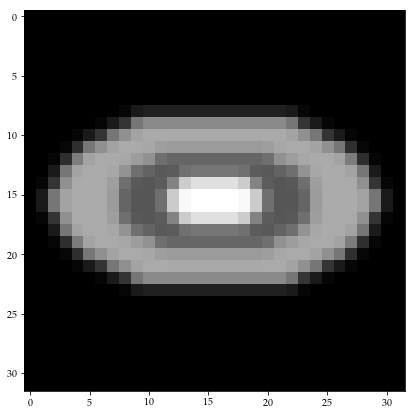

In [3]:
img_size = 32

dx = 0.7
dy = 1.3
# dx = 1.
# dy = 1.

brain_r = 30

tumour_outer_c = 0.25
tumour_outer_r = 18

tumour_inner_c = 0.75
tumour_inner_r = 9.

sigma = 2.0

img = np.zeros((img_size, img_size))
coordinates_x, coordinates_y = np.meshgrid(np.arange(1, img_size + 1), np.arange(1, img_size + 1))

center = (img_size + 1.) / 2.0
img[((coordinates_x - center) ** 2) / (brain_r / dx * img_size / 100.) ** 2 + ((coordinates_y - center) ** 2) / (brain_r / dy * img_size / 100.) ** 2 <= 1.] = 0.5
img[((coordinates_x - 0.5 * (1 + img_size)) ** 2) / (tumour_outer_r / dx * img_size / 100.) ** 2 + ((coordinates_y - 0.5 * (1 + img_size)) ** 2) / (tumour_outer_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_outer_c
img[((coordinates_x - 0.5 * (1 + img_size)) ** 2) / (tumour_inner_r / dx * img_size / 100.) ** 2 + ((coordinates_y - 0.5 * (1 + img_size)) ** 2) / (tumour_inner_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_inner_c
img = gaussian_filter(img, sigma * img_size / 100.)

figsize = 7
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(img, cmap='gray')
# plt.scatter(center, center)
plt.show()

Data generation : training and validation datasets

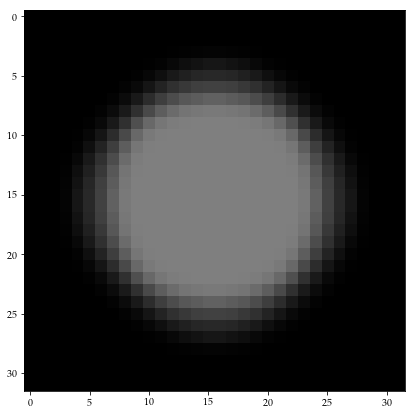

In [5]:
# Generate data

# TRAIN
path_to_folder = os.path.join(DATA_DIR, 'eyes/data_final_4/train')

if not os.path.exists(path_to_folder):
    os.makedirs(path_to_folder)

img_size = 32
center = (img_size + 1.) / 2.0
    
average = np.zeros((img_size, img_size))

k = 0
for dx in np.linspace(0.775, 1.225, 10, endpoint=True): 
    for dy in np.linspace(0.775, 1.225, 10, endpoint=True): 
        for oc in np.linspace(0.05, 0.95, 10, endpoint=True): 
            for ic in np.linspace(0.05, 0.95, 10, endpoint=True):

                brain_r = 30
                
                tumour_outer_c = oc
                tumour_outer_r = 18

                tumour_inner_c = ic
                tumour_inner_r = 9.

                sigma = 2.0

                img = np.zeros((img_size, img_size))
                coordinates_x, coordinates_y = np.meshgrid(np.arange(1, img_size + 1), np.arange(1, img_size + 1))

                center = (img_size + 1.) / 2.0
                img[((coordinates_x - center) ** 2) / (brain_r / dx * img_size / 100.) ** 2 + ((coordinates_y - center) ** 2) / (brain_r / dy * img_size / 100.) ** 2 <= 1.] = 0.5
                img[((coordinates_x - 0.5 * (1 + img_size)) ** 2) / (tumour_outer_r / dx * img_size / 100.) ** 2 + ((coordinates_y - 0.5 * (1 + img_size)) ** 2) / (tumour_outer_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_outer_c
                img[((coordinates_x - 0.5 * (1 + img_size)) ** 2) / (tumour_inner_r / dx * img_size / 100.) ** 2 + ((coordinates_y - 0.5 * (1 + img_size)) ** 2) / (tumour_inner_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_inner_c
                img = gaussian_filter(img, sigma * img_size / 100.)

                tol = 1e-10
                img = (np.clip(img, tol, 1.0 - tol) * 255).astype('uint8')
                pimg.fromarray(img).save(os.path.join(path_to_folder, 'eye__%d.png' % k))

                average += img
                k += 1
average /= float(k)

figsize = 7
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(average, cmap='gray', vmin=0, vmax=255)
plt.show()

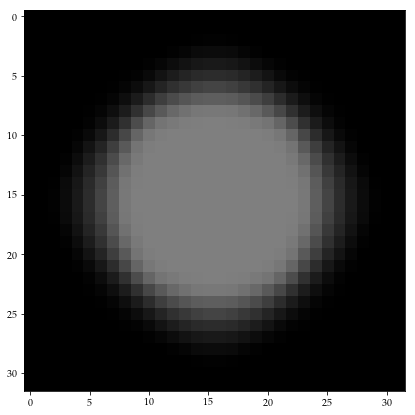

In [6]:
# Generate data

# TEST
path_to_folder = os.path.join(DATA_DIR, 'eyes/data_final_4/test')

if not os.path.exists(path_to_folder):
    os.makedirs(path_to_folder)

img_size = 32
center = (img_size + 1.) / 2.0
    
average = np.zeros((img_size, img_size))

k = 0
for dx in np.linspace(0.75, 1.25, 11, endpoint=True): 
    for dy in np.linspace(0.75, 1.25, 11, endpoint=True): 
        for oc in np.linspace(0., 1., 11, endpoint=True): 
            for ic in np.linspace(0., 1., 11, endpoint=True):

                brain_r = 30
                
                tumour_outer_c = oc
                tumour_outer_r = 18

                tumour_inner_c = ic
                tumour_inner_r = 9.

                sigma = 2.0

                img = np.zeros((img_size, img_size))
                coordinates_x, coordinates_y = np.meshgrid(np.arange(1, img_size + 1), np.arange(1, img_size + 1))

                center = (img_size + 1.) / 2.0
                img[((coordinates_x - center) ** 2) / (brain_r / dx * img_size / 100.) ** 2 + ((coordinates_y - center) ** 2) / (brain_r / dy * img_size / 100.) ** 2 <= 1.] = 0.5
                img[((coordinates_x - 0.5 * (1 + img_size)) ** 2) / (tumour_outer_r / dx * img_size / 100.) ** 2 + ((coordinates_y - 0.5 * (1 + img_size)) ** 2) / (tumour_outer_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_outer_c
                img[((coordinates_x - 0.5 * (1 + img_size)) ** 2) / (tumour_inner_r / dx * img_size / 100.) ** 2 + ((coordinates_y - 0.5 * (1 + img_size)) ** 2) / (tumour_inner_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_inner_c
                img = gaussian_filter(img, sigma * img_size / 100.)

                tol = 1e-10
                img = (np.clip(img, tol, 1.0 - tol) * 255).astype('uint8')
                pimg.fromarray(img).save(os.path.join(path_to_folder, 'eye__%d.png' % k))

                average += img
                k += 1
average /= float(k)

figsize = 7
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(average, cmap='gray', vmin=0, vmax=255)
plt.show()